## Problema

NeuralWorks en su constante búsqueda por realizar proyectos entretenidos ha decidido explorar los patrones de
movimientos de las personas para lograr una ciudad libre de autos. Hemos conseguido la data de diferentes fuentes
para entender el origen-destino de las personas para poder entender cómo eficientar el transporte público,
locaciones de puntos estratégicos, turnos entre personas con viajes similares, etc.

Como Data Engineer en este proyecto te ha tocado apoyar con la **creación de turnos entre personas con viajes
similares**. Para esto hemos adjuntado un CSV con una muestra de la data de los viajes realizados en 3 regiones. La
Data Scientist del equipo necesita tu ayuda para poder hacer un análisis profundo de los datos y construir un
modelo de machine learning. Te ha pedido cumplir con los siguientes requisitos:

1. Procesos automatizados para ingerir y almacenar los datos bajo demanda

    a. Los viajes que son similares en términos de origen, destino y hora del día deben agruparse. Describa el enfoque que utilizó para agregar viajes similares.


2. Un servicio que es capaz de proporcionar la siguiente funcionalidad: 

    a. Devuelve el promedio semanal de la cantidad de viajes para un área definida por un bounding box y la región.

    b. Informar sobre el estado de la ingesta de datos sin utilizar una solución de polling.


3. La solución debe ser escalable a 100 millones de entradas. Se recomienda simplificar los datos mediante un modelo de datos. Agregue pruebas de que la solución es escalable.


4. La solución debe estar escrita en Python usando una base de datos SQL


5. Puntos de bonificación si incluye su solución en contenedores y si dibuja cómo configuraría la aplicación en GCP

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import pickle
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("trips.csv")
df["origin_coord"] = gpd.GeoSeries.from_wkt(df["origin_coord"])
df["destination_coord"] = gpd.GeoSeries.from_wkt(df["destination_coord"])
df["datetime"] = pd.to_datetime(df["datetime"])

In [3]:
features = pd.DataFrame({
    "num_hour": df["datetime"].apply(lambda x: int(x.strftime("%H"))),
    "x_orig": df["origin_coord"].apply(lambda x: x.x),
    "y_orig": df["origin_coord"].apply(lambda x: x.y),
    "x_dest": df["destination_coord"].apply(lambda x: x.x),
    "y_dest": df["destination_coord"].apply(lambda x: x.y),
    "distance": df.apply(lambda x: x["origin_coord"].distance(x["destination_coord"]), axis=1),
})

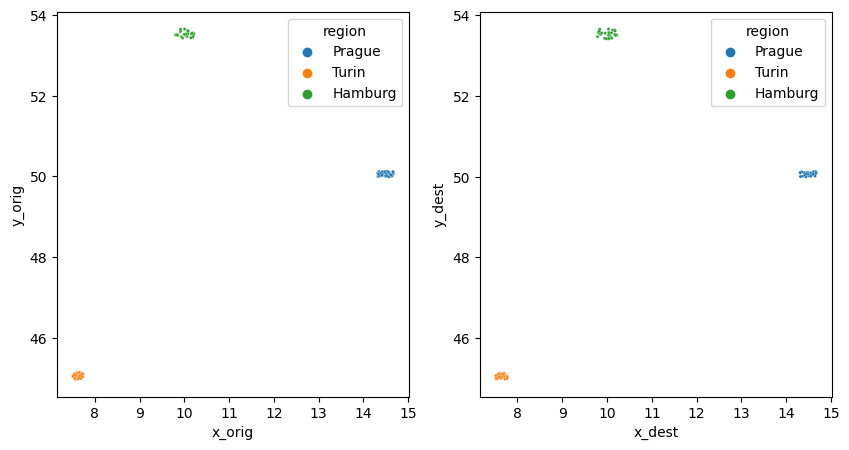

In [4]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(data=features, x="x_orig", y="y_orig", hue=df["region"], ax=ax[0], s=5)
sns.scatterplot(data=features, x="x_dest", y="y_dest", hue=df["region"], ax=ax[1], s=5)
plt.show()

In [5]:
scaler = StandardScaler()
x = scaler.fit_transform(features)

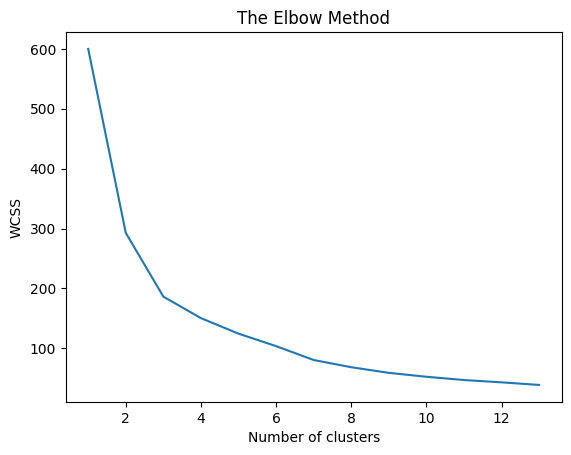

In [6]:
wcss = []
for i in range(1, 14):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state=1313)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 14), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [7]:
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=5)
y_kmeans = kmeans.fit_predict(x)
features["cluster"] = y_kmeans

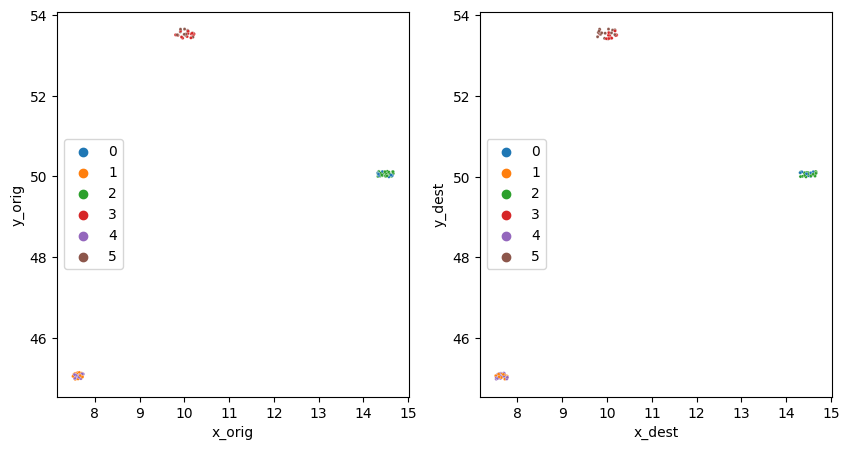

In [9]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(data=features, x="x_orig", y="y_orig", hue="cluster", ax=ax[0], s=5, palette="tab10")
sns.scatterplot(data=features, x="x_dest", y="y_dest", hue="cluster", ax=ax[1], s=5, palette="tab10")

ax[0].legend(loc='center left')
ax[1].legend(loc='center left')

plt.show()

In [10]:
with open("models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
    
with open("models/kmeans.pkl", "wb") as f:
    pickle.dump(kmeans, f)